#Install required libraries

In [1]:

!pip install xgboost imbalanced-learn seaborn plotly



#  Import libraries

In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier


#  Load and preview data

In [3]:

# IMPORTANT: Upload your dataset first (WA_Fn-UseC_-Telco-Customer-Churn.csv)
from google.colab import files
uploaded = files.upload()

# Load dataset
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print(f"Dataset shape: {df.shape}")

# Display first 5 rows
df.head()


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv
Dataset shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


#  Data cleaning

In [4]:

# Convert TotalCharges to numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Handle missing values
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

# Convert target variable
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Drop customerID
df = df.drop('customerID', axis=1)

# Display cleaned data info
print("\nData after cleaning:")
print(f"Missing values: {df.isnull().sum().sum()}")
df.info()



Data after cleaning:
Missing values: 0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  Pa

/tmp/ipython-input-4-2418063768.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


# Feature engineering

In [5]:

# Create new features
df['TenureToChargeRatio'] = df['tenure'] / (df['TotalCharges'] + 1e-5)
df['ServiceDensity'] = (df[['PhoneService', 'StreamingTV', 'StreamingMovies']] == 'Yes').sum(axis=1)

# Display new features
df[['tenure', 'TotalCharges', 'TenureToChargeRatio', 'ServiceDensity']].head()


,tenure,TotalCharges,TenureToChargeRatio,ServiceDensity
0,1,29.85,0.033501,0
1,34,1889.50,0.017994,1
2,2,108.15,0.018493,1
3,45,1840.75,0.024447,0
4,2,151.65,0.013188,1


# Eye-catching EDA visualizations

/tmp/ipython-input-6-887523575.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




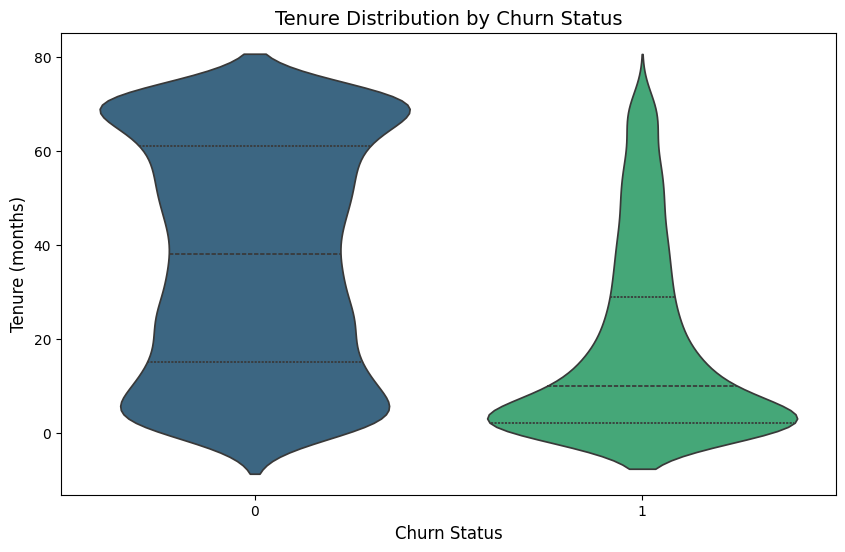

/tmp/ipython-input-6-887523575.py:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




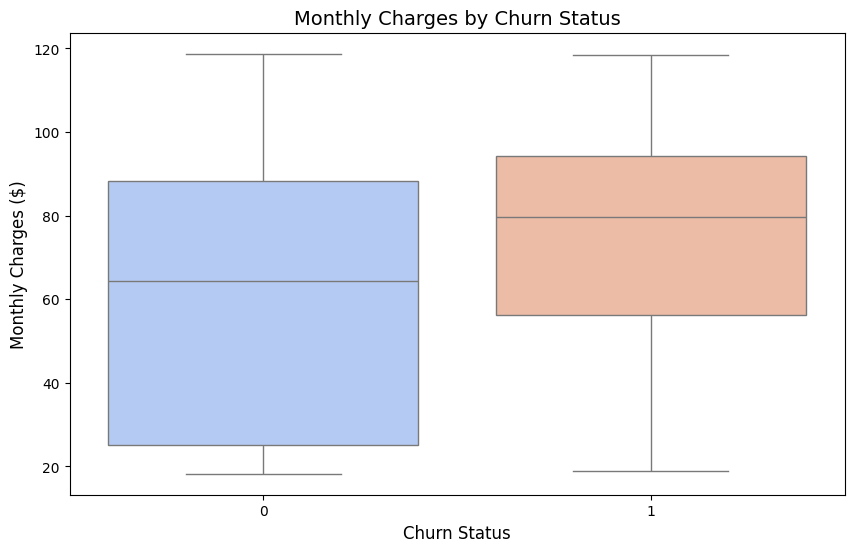

In [6]:

# 1. Churn distribution
fig = px.pie(df, names='Churn', title='Churn Distribution',
             color_discrete_sequence=['#1f77b4','#ff7f0e'])
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# 2. Tenure vs Churn
plt.figure(figsize=(10,6))
sns.violinplot(x='Churn', y='tenure', data=df, palette='viridis', inner='quartile')
plt.title('Tenure Distribution by Churn Status', fontsize=14)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Tenure (months)', fontsize=12)
plt.show()

# 3. Monthly Charges vs Churn
plt.figure(figsize=(10,6))
sns.boxplot(x='Churn', y='MonthlyCharges', data=df, palette='coolwarm')
plt.title('Monthly Charges by Churn Status', fontsize=14)
plt.xlabel('Churn Status', fontsize=12)
plt.ylabel('Monthly Charges ($)', fontsize=12)
plt.show()


# Prepare data for modeling

In [7]:

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=['object']).columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols)
    ])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Original class distribution: {pd.Series(y_train).value_counts()}")


Original class distribution: Churn
0    4139
1    1495
Name: count, dtype: int64


#  Model evaluation

In [11]:
from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Define your model
model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# Create pipeline: preprocess -> SMOTE -> model
pipeline = imbpipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', model)
])

# Fit the pipeline
pipeline.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[15:13:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges',
       'TenureToChargeRatio', 'ServiceDensity'],
      dtype='object')),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  Index(['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
       'Inte...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=500, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

# Predict on the test set

In [12]:

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

# Evaluate accuracy and AUC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.7580
ROC AUC: 0.8238

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.78      0.83      1035
           1       0.53      0.70      0.60       374

    accuracy                           0.76      1409
   macro avg       0.71      0.74      0.71      1409
weighted avg       0.79      0.76      0.77      1409



# Visualize the Confusion Matrix

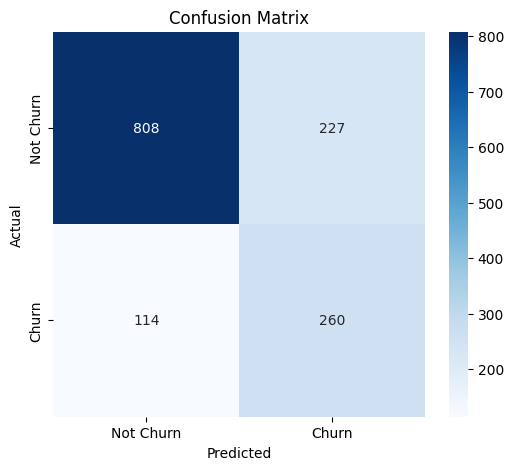

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Churn', 'Churn'], yticklabels=['Not Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# Visualize ROC Curve

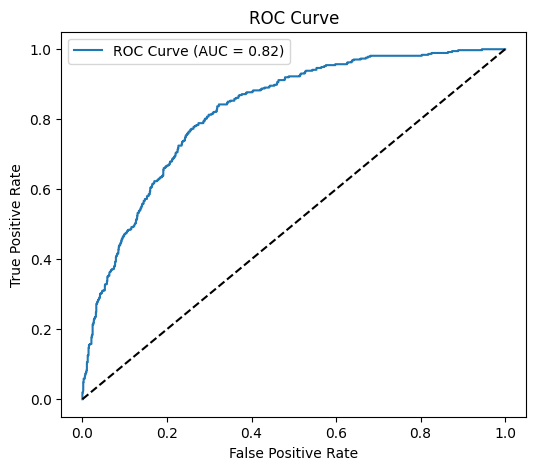

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


 # Feature Importance

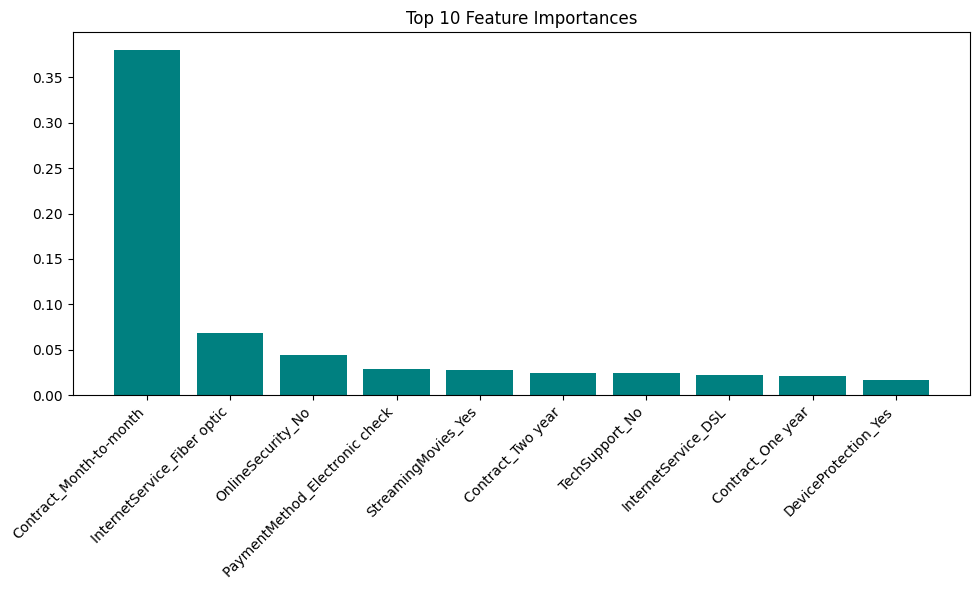

In [15]:
# Get feature names after preprocessing
cat_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat']
cat_features = cat_encoder.get_feature_names_out(cat_cols)
all_features = list(num_cols) + list(cat_features)

# Get feature importances
importances = pipeline.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Top 10 Feature Importances')
plt.bar(range(10), importances[indices][:10], color='teal')
plt.xticks(range(10), [all_features[i] for i in indices[:10]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [16]:
# Predict churn probability for a new (or sample) customer
sample = X_test.sample(1, random_state=42)
proba = pipeline.predict_proba(sample)[:, 1][0]
print(f"Predicted churn probability: {proba:.2f}")


Predicted churn probability: 0.19


In [17]:
import joblib
joblib.dump(pipeline, 'churn_prediction_pipeline.pkl')


['churn_prediction_pipeline.pkl']

In [18]:
results = X_test.copy()
results['ActualChurn'] = y_test
results['PredictedChurn'] = y_pred
results['ChurnProbability'] = y_proba
results.to_csv('churn_predictions_with_probs.csv', index=False)
